<a href="https://colab.research.google.com/github/Davegdd/ML-drug-repurposing-for-H5N1-virus/blob/main/ML_drug_repurposing_for_H5N1_virus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ML drug repurposing for highly pathogenic H5N1 virus**

A bird-adapted strain of H5N1, called HPAI A(H5N1) for highly pathogenic avian influenza virus of type A of subtype H5N1, is the highly pathogenic causative agent of H5N1 flu, commonly known as avian influenza ("bird flu").

Around 60% of humans known to have been infected with the Asian strain of HPAI A(H5N1) have died from it, and H5N1 may mutate or reassort into a strain capable of efficient human-to-human transmission.

In 2007 the Centers for Disease Control and Prevention estimated that the economic impact of the next influenza pandemic could cost the United States billions of dollars, devastate the world economy and potentially kill one billion people worldwide.

In this notebook we will see how we could try to shortlist drug candidates for the treatment of H5N1 using the deepearning toolkits DeepChem and DeepPurpose among other software. It is intended to be a general example of the capabilities and not a comprehensive analysis.

## 1. Drug screening

We will start by using a onliner included with DeepPurpose to check which antivirals from a curated list could potentially inhibit H5N1.

The literature seems to suggest that the enhanced virulence of the HPAI H5N1 strain may be due in part to its NS1 protein, so we will levarage [bioassay data](https://pubchem.ncbi.nlm.nih.gov/bioassay/2326) on a slightly different NS1 protein, the one from H1N1. We will train 5 different preconfigured models to learn which drugs do and do not act against H1N1 NS1 and then predict against a slightly different target: H5N1 NS1.

In [ ]:
# install packages
!pip install DeepPurpose
!pip install rdkit
!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install pandas-flavor

Loading customized repurposing dataset...
Beginning Downloading Configs Files for training from scratch...
Dataset already downloaded in the local system...
Training on your own customized data...
Drug Target Interaction Prediction Mode...
in total: 13530 drug-target pairs
encoding drug...
unique drugs: 13524
encoding protein...
unique target sequence: 1
splitting dataset...
Done.
Training from scrtach...
Begin to train model 0 with drug encoding MPNN and target encoding CNN
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67318. Total time 0.00222 hours
Training at Epoch 1 iteration 100 with loss 0.24457. Total time 0.00472 hours
Training at Epoch 1 iteration 200 with loss 0.31489. Total time 0.00694 hours
Training at Epoch 1 iteration 300 with loss 0.38075. Total time 0.00944 hours
Validation at Epoch 1, AUROC: 0.59382 , AUPRC: 0.13294 , F1: 0.0 , Cross-entropy Loss: 2.83565
Training at Epoch 2 iteration 0 with loss 0.23227

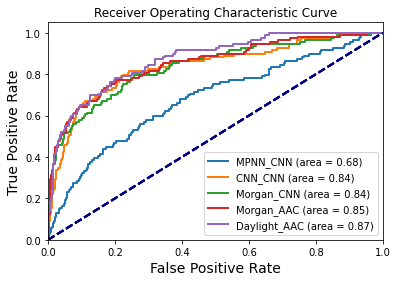

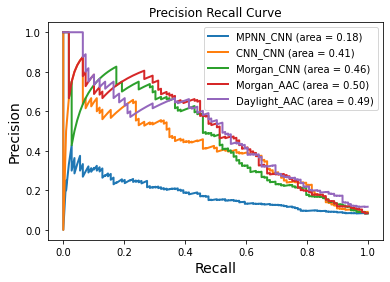

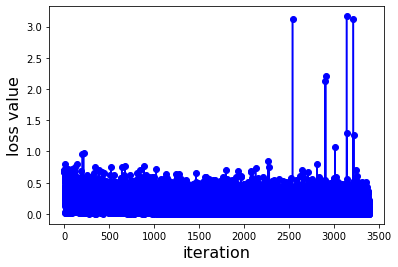

In [ ]:
# train 5 preconfigured models with different combinations of drug/target encoding
# on our H1N1 NS1 data and predict potential candidates on our H5N1 NS1 sequence from
# a preestablished antivirals list.
from DeepPurpose import oneliner
from DeepPurpose.dataset import *

oneliner.repurpose(*read_file_target_sequence("PATH_TO/H5N1_NS1.txt"), *load_antiviral_drugs(no_cid = True),  *read_file_training_dataset_bioassay("PATH_TO/H1N1_bioassay_small.txt"), \
		split='HTS', convert_y = False, frac=[0.8,0.1,0.1], pretrained = False, agg = 'max_effect')

Out of the top results, [Foscarnet](https://pubmed.ncbi.nlm.nih.gov/2524368/), [Docosanol](https://www.researchgate.net/publication/314112588_Antiviral_Activity_and_Molecular_Targets_of_Plant_Natural_Products_Against_Avian_Influenza_Virus) and [Zanamivir](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC90446/) appear in the literature as having confirmed or potential anti-H5N1 (specifically) or anti-Influenza (more generally) properties. 

Next, to increase the pool of potential drugs we will perform drug property prediction, being inhibition of H5N1 the property to predict. We will approach this as a binary classification problem (0 = inactive, 1 = active). In this case we do not have a specific protein target but a general inhibition/non-inhibition property against H5N1 so we will use high throughput screening [data on exactly H5N1](https://pubchem.ncbi.nlm.nih.gov/bioassay/740#section=Description) and not any of its cousins as before. After learning which molecules are active and inactive the model will be applied to the Broad Institute database of more than 6000 compounds to check if any of them has a similar inhibition property.

Drug Property Prediction Mode...
in total: 41587 drugs
encoding drug...
unique drugs: 41586
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67923. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.00079. Total time 0.00027 hours
Training at Epoch 1 iteration 200 with loss 0.00176. Total time 0.00083 hours
Validation at Epoch 1 , AUROC: 0.52549 , AUPRC: 0.00079 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.00172. Total time 0.00111 hours
Training at Epoch 2 iteration 100 with loss 0.00160. Total time 0.00138 hours
Training at Epoch 2 iteration 200 with loss 0.00146. Total time 0.00194 hours
Validation at Epoch 2 , AUROC: 0.64192 , AUPRC: 0.00103 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.00239. Total time 0.00222 hours
Training at Epoch 3 iteration 100 with loss 0.12321. Total time 0.00277 hours
Training at Epoch 3 iteration 200 with loss 0.00256. Total time 0.00305 hours
Validation a

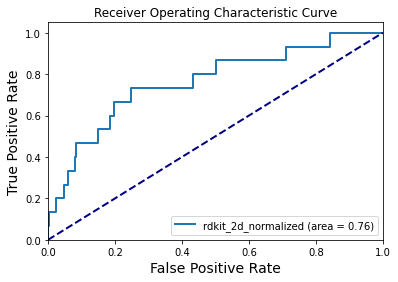

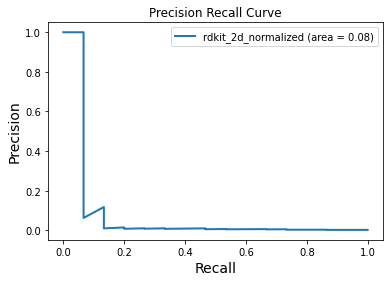

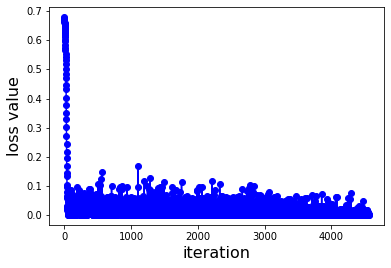

In [3]:
from DeepPurpose import CompoundPred as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
from DeepPurpose import dataset

# load H5N1 assay data
y, X_drugs = dataset.read_file_compound_property("PATH_TO/H5N1_bioassay_small.txt")
y = y.astype(float)

drug_encoding = 'rdkit_2d_normalized'
train, val, test = data_process(X_drug = X_drugs, y = y, 
			    drug_encoding = drug_encoding,
			    split_method='HTS',
			    random_seed = 1)

config = generate_config(drug_encoding = drug_encoding, 
                         cls_hidden_dims = [512], 
                         train_epoch = 20, 
                         LR = 0.0001, 
                         batch_size = 128,
                        )
model = models.model_initialize(**config)
model.train(train, val, test)

X_repurpose, drug_name, drug_cid = load_broad_repurposing_hub("SAVE_PATH")

_ = models.repurpose(X_repurpose, model, drug_name)


At first sight, and judging by the metrics and probability results, these potential inhibitors do not seem that relevant. However, a quick literature search reveals that [MK2206](https://pubmed.ncbi.nlm.nih.gov/24752266/) inhibits pH1N1 in vitro (although not H5N1) and Amg-548 appears associated to prevention of severe influenza in some sources.

It is important to mention that due to hardware limitations we only used a fraction of the 200k and 95k datapoints in each bioassay, respectively, to train the models. For the same reason we did not perform an in depth hyperparameter optimization. So we could expect even better results by leveraging the full data and optimization options available.

## 2. Toxicity

Toxicity is one of the most important factors to take into account when considering compounds for treatment in humans. After obtaining an initial shorlist of candidates we can try to predict the toxicity of those compounds for which there is no relevant toxicity information in order to discard the most toxic ones and narrow down our search.

For this we will use the tool suite DeepChem and the Tox21 dataset that contains about 8k compounds, for each of them there are 12 binary labels that represent the outcome (active/inactive) of 12 different toxicological experiments.

After trying two different approaches, Multitask Model (fully connected network) vs Graph Convolutional Model, the latter seemed to provide more meaningful results so we will use a Graph Convolutional Model.

We will also use Hyperopt to find the best hyperparameters for the model.

In [ ]:
# install packages
!pip install --pre deepchem
!pip install hyperopt

In [2]:
import deepchem as dc
dc.__version__

'2.6.1'

We choose butina splitter (that clusters molecules based on their molecular fingerprints) to perform an appropriate split of the datasets since after several experiments it appeared to yield better results at inference.

In [3]:
# load dataset
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv', splitter= "butina")
train_dataset, valid_dataset, test_dataset = datasets

In [4]:
from hyperopt import hp, fmin, tpe, Trials

In [5]:
# define hyperparameter search space
search_space = {
    'graph_conv_layers': hp.choice('graph_conv_layers', [[32, 32], [64, 64], [128, 128]]),
    'dense_layer_size': hp.choice('dense_layer_size', [64, 128, 576]),
    'number_atom_features': hp.choice('number_atom_features',[[75], [100], [2000]]),
    'dropouts': hp.uniform('dropout',low=0.2, high=0.5),
    'learning_rate': hp.uniform('learning_rate',high=0.001, low=0.0001)
}


Hyperopt will try to minimize a given function, since our metric is ROC AUC which has to be maximized, we return its negative which will be the one minimized, i.e., ROC AUC maximized. We also establish a validation callback to validate the classifier every 1000 steps.

In [6]:
import tempfile
# tempfile is used to save the best checkpoint later in the program.

metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

def fm(args):
  save_dir = tempfile.mkdtemp()
  model = dc.models.GraphConvModel(n_tasks = len(tasks), mode='classification', number_atom_features=args['number_atom_features'], graph_conv_layers=args['graph_conv_layers'], dense_layer_size=args['dense_layer_size'], dropouts=args['dropouts'], learning_rate=args['learning_rate'])
  # validation callback that saves the best checkpoint, i.e the one with the maximum score.
  validation=dc.models.ValidationCallback(valid_dataset, 1000, [metric],save_dir=save_dir,transformers=transformers,save_on_minimum=False)
  
  model.fit(train_dataset, nb_epoch=25,callbacks=validation)

  # restoring the best checkpoint and passing the negative of its validation score to be minimized.
  model.restore(model_dir=save_dir)
  valid_score = model.evaluate(valid_dataset, [metric], transformers)

  return -1*valid_score['roc_auc_score']

It is recommended to set the number of evaluation epochs (max_evals) at 10–30 times the number of hyperparameters defined in the search space to optimise for performance and computation time, so we will set it at 50 (=5x10).

In [8]:
# the next line filters tensorflow warnings relevant to memory consumption.
# to see these warnings, comment the next line.
import warnings; warnings.filterwarnings('ignore')

trials=Trials()
best = fmin(fm,
    		space= search_space,
    		algo=tpe.suggest,
    		max_evals=50,
    		trials = trials)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

Step 1000 validation: roc_auc_score=0.696532
  2%|▏         | 1/50 [00:38<31:14, 38.27s/it, best loss: -0.6965321991966763]

Step 1000 validation: roc_auc_score=0.685164
100%|██████████| 50/50 [31:11<00:00, 37.43s/it, best loss: -0.7382335574634968]


In [9]:
print("Best: {}".format(best))

Best: {'dense_layer_size': 1, 'dropout': 0.29529814040651553, 'graph_conv_layers': 2, 'learning_rate': 0.0009984892020989185, 'number_atom_features': 1}


As we can see, the best combination found is a dense layer size of 128, dropout rate of 0.2952, graph conv layer of 128x128, learning rate of 0.000998 and number of atom features 100. We could have defined a bigger or more diverse search space but this one seems enough as an example and to obtain good results.

In [10]:
# input the obtained hyperparameteres and train
model = dc.models.GraphConvModel(n_tasks = len(tasks), mode='classification', number_atom_features=100, graph_conv_layers=[128, 128], dense_layer_size=128, dropouts=0.29529814040651553, learning_rate=0.0009984892020989185)
model.fit(train_dataset, nb_epoch=50)

0.24201208114624023

In [11]:
# evaluate the best model on training and test sets
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print(f'Training set score: {model.evaluate(train_dataset, [metric], transformers)["roc_auc_score"]:.2f}')
print(f'Test set score: {model.evaluate(test_dataset, [metric], transformers)["roc_auc_score"]:.2f}')

Training set score: 0.97
Test set score: 0.64


In [12]:
# create custom dataset of drug candidates compatible with our model
# we will use Foscarnet, Methisazone and Zanamivir (respectively in the list below) as an example
inhibitors = ["C(=O)(O)P(=O)(O)O", "CN1C2=CC=CC=C2C(=C1O)N=NC(=S)N", "CC(=O)N[C@@H]1[C@H](C=C(O[C@H]1[C@@H]([C@@H](CO)O)O)C(=O)O)N=C(N)N"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks), featurizer=featurizer)
dataset = loader.create_dataset(inhibitors, shard_size=1)

To better visualize the results we use a heatmap from the seaborn library where the x axis is the [task](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5/tables/3) (or toxicology experiment) number, the y axis is the compound and the color represents toxicity (from black = non-toxic to white = most toxic).

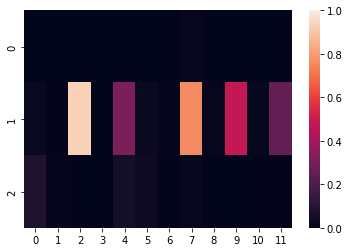

In [13]:
predictions = model.predict(dataset, transformers)[:, :, 1]

import seaborn as sns
sns.heatmap(predictions, vmin=0, vmax=1)

In the previous graph we can easily see that, according to the model, the most toxic scenario is compound 1 (Methisazone) on task 2 (aryl hydrocarbon receptor). A [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7097272/) search reveals associations between Methisazone and severe side effects.

To double check our model we can also test it on compounds we know are highly toxic or innocuous. Below we test on Novichok (a nerve agent chemical weapon) and Aspirin. The results show no relevant toxicity on Aspirin and a high toxicity of Novichok on task 7, as could be expected:

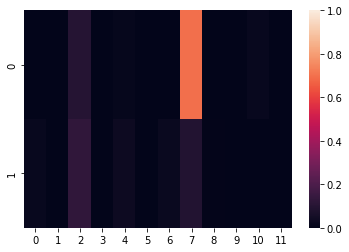

In [17]:
compounds = ["COP(=O)(ON=C(Cl)Cl)F", "CC(=O)OC1=CC=CC=C1C(=O)O"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks), featurizer=featurizer)
dataset = loader.create_dataset(compounds, shard_size=1)
predictions = model.predict(dataset, transformers)[:, :, 1]
sns.heatmap(predictions, vmin=0, vmax=1)

## 3. ADME

ADME is an abbreviation in pharmacokinetics and pharmacology for "absorption, distribution, metabolism, and excretion", a critical part in drug discovery that describes the disposition of a pharmaceutical compound within an organism.

We will go back to using DeepPurpose as well as the Harvard initiative *Therapeutics Data Commons* (TDC), a platform for therapeutics with machine learning. We will train a Message Passing Neural Network (MPNN) on the 21 different tasks (or subdatasets) of the ADME dataset, thus getting 21 different ADME predictions for our drug candidates. Not all of them will be relevant for all drugs ([more info on page 11 here](https://arxiv.org/pdf/2102.09548.pdf) for units and the meaning of each subdataset).

In [ ]:
# install packages
!pip install DeepPurpose
!pip install rdkit
!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install pandas-flavor
!pip install PyTDC --upgrade

In [ ]:
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME

Downloading...


lipophilicity_astrazeneca


100%|██████████| 298k/298k [00:00<00:00, 438kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 4200 drugs
encoding drug...
unique drugs: 4200
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 6.12854. Total time 0.00055 hours
Validation at Epoch 1 , MSE: 1.54566 , Pearson Correlation: 0.38080 with p-value: 6.09E-16 , Concordance Index: 0.64065
Training at Epoch 2 iteration 0 with loss 1.40061. Total time 0.00083 hours
Validation at Epoch 2 , MSE: 1.32573 , Pearson Correlation: 0.52260 with p-value: 8.24E-31 , Concordance Index: 0.68138
Training at Epoch 3 iteration 0 with loss 1.23678. Total time 0.00083 hours
Validation at Epoch 3 , MSE: 0.87170 , Pearson Correlation: 0.63783 with p-value: 2.39E-49 , Concordance Index: 0.72602
Training at Epoch 4 iteration 0 with loss 0.57390. Total time 0.00111 hours
Validation at Epoch 4 , MSE: 0.75439 , Pearson Correlation: 0.69691 with p-value: 2.46E-62 , Concordance Index: 0.74850
Training at Epoch 5 iteration 0 with loss 0.28649. Tot

Downloading...


--- Training Finished ---
solubility_aqsoldb


100%|██████████| 853k/853k [00:00<00:00, 927kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 9982 drugs
encoding drug...
unique drugs: 9982
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 16.4319. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2.68098 , Pearson Correlation: 0.75218 with p-value: 1.27E-182 , Concordance Index: 0.77801
Training at Epoch 2 iteration 0 with loss 2.74469. Total time 0.00027 hours
Validation at Epoch 2 , MSE: 1.87059 , Pearson Correlation: 0.81970 with p-value: 2.84E-243 , Concordance Index: 0.80886
Training at Epoch 3 iteration 0 with loss 1.70955. Total time 0.00055 hours
Validation at Epoch 3 , MSE: 1.66181 , Pearson Correlation: 0.83735 with p-value: 1.76E-263 , Concordance Index: 0.82179
Training at Epoch 4 iteration 0 with loss 0.44380. Total time 0.00083 hours
Validation at Epoch 4 , MSE: 1.59553 , Pearson Correlation: 0.83914 with p-value: 1.16E-265 , Concordance Index: 0.82204
Training at Epoch 5 iteration 0 with loss 0.50566. Tot

Downloading...


Testing MSE: 1.8009204209129401 , Pearson Correlation: 0.8267502933202813 with p-value: 0.00E+00 , Concordance Index: 0.8225606497164925
--- Training Finished ---
hydrationfreeenergy_freesolv


100%|██████████| 29.0k/29.0k [00:00<00:00, 7.03MiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 642 drugs
encoding drug...
unique drugs: 642
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 22.4876. Total time 0.0 hours
Validation at Epoch 1 , MSE: 28.0937 , Pearson Correlation: 0.37147 with p-value: 2.51E-03 , Concordance Index: 0.62952
Training at Epoch 2 iteration 0 with loss 14.8044. Total time 0.0 hours
Validation at Epoch 2 , MSE: 12.0456 , Pearson Correlation: 0.48730 with p-value: 4.43E-05 , Concordance Index: 0.66873
Training at Epoch 3 iteration 0 with loss 11.2836. Total time 0.0 hours
Validation at Epoch 3 , MSE: 19.5380 , Pearson Correlation: 0.64189 with p-value: 1.09E-08 , Concordance Index: 0.72431
Training at Epoch 4 iteration 0 with loss 13.2521. Total time 0.0 hours
Validation at Epoch 4 , MSE: 12.8000 , Pearson Correlation: 0.68560 with p-value: 4.09E-10 , Concordance Index: 0.75459
Training at Epoch 5 iteration 0 with loss 6.46761. Total time 0.0 hours


Downloading...


Validation at Epoch 5 , MSE: 7.70764 , Pearson Correlation: 0.71711 with p-value: 2.64E-11 , Concordance Index: 0.77096
--- Go for Testing ---
Testing MSE: 12.96456541631111 , Pearson Correlation: 0.6265574224483441 with p-value: 2.56E-15 , Concordance Index: 0.7665886987566171
--- Training Finished ---
caco2_wang


100%|██████████| 82.5k/82.5k [00:00<00:00, 356kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 910 drugs
encoding drug...
unique drugs: 906
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 26.9236. Total time 0.0 hours
Validation at Epoch 1 , MSE: 1.82967 , Pearson Correlation: 0.28331 with p-value: 6.50E-03 , Concordance Index: 0.58629
Training at Epoch 2 iteration 0 with loss 1.63924. Total time 0.0 hours
Validation at Epoch 2 , MSE: 8.04842 , Pearson Correlation: 0.36206 with p-value: 4.21E-04 , Concordance Index: 0.61105
Training at Epoch 3 iteration 0 with loss 7.20440. Total time 0.0 hours
Validation at Epoch 3 , MSE: 6.23260 , Pearson Correlation: 0.48603 with p-value: 1.04E-06 , Concordance Index: 0.65175
Training at Epoch 4 iteration 0 with loss 5.65017. Total time 0.0 hours
Validation at Epoch 4 , MSE: 2.40635 , Pearson Correlation: 0.55418 with p-value: 1.21E-08 , Concordance Index: 0.68926


Downloading...


Training at Epoch 5 iteration 0 with loss 2.80305. Total time 0.0 hours
Validation at Epoch 5 , MSE: 0.50407 , Pearson Correlation: 0.62448 with p-value: 3.72E-11 , Concordance Index: 0.71353
--- Go for Testing ---
Testing MSE: 0.5857518526019042 , Pearson Correlation: 0.6948014780452515 with p-value: 1.45E-27 , Concordance Index: 0.7514289188860513
--- Training Finished ---
hia_hou


100%|██████████| 40.1k/40.1k [00:00<00:00, 11.3MiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70076. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.61904 , AUPRC: 0.93018 , F1: 0.93577
Training at Epoch 2 iteration 0 with loss 0.33839. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76190 , AUPRC: 0.96345 , F1: 0.93577
Training at Epoch 3 iteration 0 with loss 0.37248. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.81512 , AUPRC: 0.97172 , F1: 0.93577
Training at Epoch 4 iteration 0 with loss 0.30485. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.82913 , AUPRC: 0.97348 , F1: 0.93577
Training at Epoch 5 iteration 0 with loss 0.24512. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.83193 , AUPRC: 0.97342 , F1: 0.93577
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8699669966996699 , AUPRC: 0.9730506102790429 , F1: 0.9308755760368664
--- Training Finished ---
pgp_broccatelli


100%|██████████| 126k/126k [00:00<00:00, 277kiB/s] 
Loading...
Done!


Drug Property Prediction Mode...
in total: 1218 drugs
encoding drug...
unique drugs: 1212
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69198. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.87361 , AUPRC: 0.92436 , F1: 0.74226
Training at Epoch 2 iteration 0 with loss 0.62262. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.83805 , AUPRC: 0.91915 , F1: 0.81751
Training at Epoch 3 iteration 0 with loss 0.37994. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.92555 , AUPRC: 0.95791 , F1: 0.85271
Training at Epoch 4 iteration 0 with loss 0.17277. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.94083 , AUPRC: 0.96826 , F1: 0.88888
Training at Epoch 5 iteration 0 with loss 0.09865. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.91555 , AUPRC: 0.95382 , F1: 0.84892
--- Go for Testing ---


Downloading...


Testing AUROC: 0.9293682795698925 , AUPRC: 0.9453258022750618 , F1: 0.8699186991869918
--- Training Finished ---
bioavailability_ma


100%|██████████| 43.7k/43.7k [00:00<00:00, 190kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 640 drugs
encoding drug...
unique drugs: 640
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68482. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.54285 , AUPRC: 0.82524 , F1: 0.86725
Training at Epoch 2 iteration 0 with loss 0.54350. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.73333 , AUPRC: 0.91349 , F1: 0.86725
Training at Epoch 3 iteration 0 with loss 0.49717. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.75510 , AUPRC: 0.91761 , F1: 0.86725
Training at Epoch 4 iteration 0 with loss 0.51286. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.77687 , AUPRC: 0.92515 , F1: 0.86725
Training at Epoch 5 iteration 0 with loss 0.32408. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.79183 , AUPRC: 0.93294 , F1: 0.86725
--- Go for Testing ---
Testing AUROC: 0.6715265866209262 , AUPRC: 0.9033731554367992 , F1: 0.905982905982906
--- Training Finished

Downloading...


vdss_lombardo


100%|██████████| 89.9k/89.9k [00:00<00:00, 386kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 1130 drugs
encoding drug...
unique drugs: 1111
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 196.121. Total time 0.0 hours
Validation at Epoch 1 , MSE: 29.3112 , Pearson Correlation: 0.29932 with p-value: 1.28E-03 , Concordance Index: 0.56609
Training at Epoch 2 iteration 0 with loss 193.833. Total time 0.0 hours
Validation at Epoch 2 , MSE: 20.5185 , Pearson Correlation: 0.44009 with p-value: 1.07E-06 , Concordance Index: 0.67268
Training at Epoch 3 iteration 0 with loss 50.9720. Total time 0.0 hours
Validation at Epoch 3 , MSE: 19.2250 , Pearson Correlation: 0.41136 with p-value: 6.00E-06 , Concordance Index: 0.70482
Training at Epoch 4 iteration 0 with loss 12.8961. Total time 0.0 hours
Validation at Epoch 4 , MSE: 26.7430 , Pearson Correlation: 0.26625 with p-value: 4.37E-03 , Concordance Index: 0.67793
Training at Epoch 5 iteration 0 with loss 29.8053. Total time 0.0 hour

Downloading...


--- Training Finished ---
cyp2c19_veith


100%|██████████| 771k/771k [00:00<00:00, 843kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 12665 drugs
encoding drug...
unique drugs: 12665
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69239. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.85857 , AUPRC: 0.83170 , F1: 0.78410
Training at Epoch 2 iteration 0 with loss 0.37718. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.85826 , AUPRC: 0.83125 , F1: 0.76910
Training at Epoch 3 iteration 0 with loss 0.32148. Total time 0.00111 hours
Validation at Epoch 3 , AUROC: 0.85215 , AUPRC: 0.81848 , F1: 0.78700
Training at Epoch 4 iteration 0 with loss 0.16214. Total time 0.00166 hours
Validation at Epoch 4 , AUROC: 0.84783 , AUPRC: 0.81694 , F1: 0.76821
Training at Epoch 5 iteration 0 with loss 0.06832. Total time 0.00194 hours
Validation at Epoch 5 , AUROC: 0.83667 , AUPRC: 0.80233 , F1: 0.74587
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8581274066791452 , AUPRC: 0.8015866023174549 , F1: 0.7755102040816326
--- Training Finished ---
cyp2d6_veith


100%|██████████| 800k/800k [00:01<00:00, 704kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 13130 drugs
encoding drug...
unique drugs: 13130
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68016. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.77981 , AUPRC: 0.51786 , F1: 0.36746
Training at Epoch 2 iteration 0 with loss 0.37290. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.80718 , AUPRC: 0.55813 , F1: 0.52093
Training at Epoch 3 iteration 0 with loss 0.17882. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.79408 , AUPRC: 0.55737 , F1: 0.47826
Training at Epoch 4 iteration 0 with loss 0.23246. Total time 0.00111 hours
Validation at Epoch 4 , AUROC: 0.78988 , AUPRC: 0.56244 , F1: 0.51901
Training at Epoch 5 iteration 0 with loss 0.03585. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.78385 , AUPRC: 0.55098 , F1: 0.50877
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8430532107074118 , AUPRC: 0.6824524013798995 , F1: 0.5920651068158699
--- Training Finished ---
cyp3a4_veith


100%|██████████| 746k/746k [00:01<00:00, 653kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 12328 drugs
encoding drug...
unique drugs: 12328
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69479. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.86722 , AUPRC: 0.83600 , F1: 0.73110
Training at Epoch 2 iteration 0 with loss 0.33341. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.88135 , AUPRC: 0.85724 , F1: 0.76162
Training at Epoch 3 iteration 0 with loss 0.27329. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.87253 , AUPRC: 0.85367 , F1: 0.73899
Training at Epoch 4 iteration 0 with loss 0.16805. Total time 0.00083 hours
Validation at Epoch 4 , AUROC: 0.86491 , AUPRC: 0.84248 , F1: 0.74044
Training at Epoch 5 iteration 0 with loss 0.09852. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.87699 , AUPRC: 0.85664 , F1: 0.75849
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8790735124399475 , AUPRC: 0.8451670741888052 , F1: 0.7700987306064879
--- Training Finished ---
cyp1a2_veith


100%|██████████| 760k/760k [00:01<00:00, 663kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 12579 drugs
encoding drug...
unique drugs: 12579
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69343. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.90203 , AUPRC: 0.89459 , F1: 0.81105
Training at Epoch 2 iteration 0 with loss 0.37346. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.91303 , AUPRC: 0.90481 , F1: 0.82323
Training at Epoch 3 iteration 0 with loss 0.20539. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.91618 , AUPRC: 0.91240 , F1: 0.83434
Training at Epoch 4 iteration 0 with loss 0.06047. Total time 0.00111 hours
Validation at Epoch 4 , AUROC: 0.91300 , AUPRC: 0.89492 , F1: 0.83262
Training at Epoch 5 iteration 0 with loss 0.02488. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.90176 , AUPRC: 0.88586 , F1: 0.81222
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8867920696054861 , AUPRC: 0.8799285447089442 , F1: 0.7974468085106383
--- Training Finished ---
cyp2c9_veith


100%|██████████| 740k/740k [00:01<00:00, 645kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 12092 drugs
encoding drug...
unique drugs: 12092
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69861. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.85638 , AUPRC: 0.71897 , F1: 0.68734
Training at Epoch 2 iteration 0 with loss 0.35478. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.87780 , AUPRC: 0.76219 , F1: 0.71952
Training at Epoch 3 iteration 0 with loss 0.24999. Total time 0.00083 hours
Validation at Epoch 3 , AUROC: 0.86759 , AUPRC: 0.74163 , F1: 0.69852
Training at Epoch 4 iteration 0 with loss 0.13472. Total time 0.00111 hours
Validation at Epoch 4 , AUROC: 0.87583 , AUPRC: 0.75128 , F1: 0.70468
Training at Epoch 5 iteration 0 with loss 0.03241. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.86496 , AUPRC: 0.74496 , F1: 0.69520
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8705190405876586 , AUPRC: 0.7709985351306786 , F1: 0.7093712930011863
--- Training Finished ---
cyp2c9_substrate_carbonmangels


100%|██████████| 45.6k/45.6k [00:00<00:00, 199kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 669 drugs
encoding drug...
unique drugs: 666
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67462. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.50512 , AUPRC: 0.24854 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.50081. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.57948 , AUPRC: 0.27412 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.50388. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.59102 , AUPRC: 0.27890 , F1: 0.0
Training at Epoch 4 iteration 0 with loss 0.34463. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.6 , AUPRC: 0.28968 , F1: 0.0
Training at Epoch 5 iteration 0 with loss 0.29570. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.60256 , AUPRC: 0.30258 , F1: 0.0
--- Go for Testing ---


Downloading...


Testing AUROC: 0.6275527864312911 , AUPRC: 0.3590250948240035 , F1: 0.0
--- Training Finished ---
cyp2d6_substrate_carbonmangels


100%|██████████| 45.4k/45.4k [00:00<00:00, 199kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 667 drugs
encoding drug...
unique drugs: 664
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68294. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.64389 , AUPRC: 0.48753 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.52882. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.74948 , AUPRC: 0.62182 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.53294. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.77743 , AUPRC: 0.66510 , F1: 0.0
Training at Epoch 4 iteration 0 with loss 0.55196. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.77639 , AUPRC: 0.65843 , F1: 0.0
Training at Epoch 5 iteration 0 with loss 0.50231. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.79399 , AUPRC: 0.71034 , F1: 0.0
--- Go for Testing ---


Downloading...


Testing AUROC: 0.7911764705882354 , AUPRC: 0.6973336541845604 , F1: 0.0
--- Training Finished ---
cyp3a4_substrate_carbonmangels


100%|██████████| 46.0k/46.0k [00:00<00:00, 202kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 670 drugs
encoding drug...
unique drugs: 667
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69506. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.61290 , AUPRC: 0.57434 , F1: 0.63265
Training at Epoch 2 iteration 0 with loss 0.70480. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.62634 , AUPRC: 0.58379 , F1: 0.63265
Training at Epoch 3 iteration 0 with loss 0.66472. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.61827 , AUPRC: 0.59774 , F1: 0.63265
Training at Epoch 4 iteration 0 with loss 0.56882. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.63799 , AUPRC: 0.63265 , F1: 0.63265
Training at Epoch 5 iteration 0 with loss 0.46171. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.67114 , AUPRC: 0.65115 , F1: 0.67647
--- Go for Testing ---


Downloading...


Testing AUROC: 0.6818181818181818 , AUPRC: 0.6287220112952091 , F1: 0.6901408450704226
--- Training Finished ---
bbb_martins


100%|██████████| 138k/138k [00:00<00:00, 294kiB/s] 
Loading...
Done!


Drug Property Prediction Mode...
in total: 2030 drugs
encoding drug...
unique drugs: 1975
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69195. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.87741 , AUPRC: 0.95665 , F1: 0.86592
Training at Epoch 2 iteration 0 with loss 0.44348. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.89489 , AUPRC: 0.96324 , F1: 0.86592
Training at Epoch 3 iteration 0 with loss 0.35376. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.89475 , AUPRC: 0.96460 , F1: 0.92211
Training at Epoch 4 iteration 0 with loss 0.20056. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.91935 , AUPRC: 0.97193 , F1: 0.92105
Training at Epoch 5 iteration 0 with loss 0.12432. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.91411 , AUPRC: 0.96963 , F1: 0.91205
--- Go for Testing ---


Downloading...


Testing AUROC: 0.8628257223942208 , AUPRC: 0.9301046439338839 , F1: 0.900990099009901
--- Training Finished ---
ppbr_az


100%|██████████| 214k/214k [00:00<00:00, 463kiB/s] 
Loading...
Done!


Drug Property Prediction Mode...
in total: 2790 drugs
encoding drug...
unique drugs: 1797
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 7924.65. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2580.97 , Pearson Correlation: 0.28859 with p-value: 9.41E-07 , Concordance Index: 0.55818
Training at Epoch 2 iteration 0 with loss 2588.93. Total time 0.0 hours
Validation at Epoch 2 , MSE: 420.238 , Pearson Correlation: 0.46833 with p-value: 1.29E-16 , Concordance Index: 0.63628
Training at Epoch 3 iteration 0 with loss 423.529. Total time 0.0 hours
Validation at Epoch 3 , MSE: 260.229 , Pearson Correlation: 0.59329 with p-value: 6.41E-28 , Concordance Index: 0.68972
Training at Epoch 4 iteration 0 with loss 311.241. Total time 0.0 hours
Validation at Epoch 4 , MSE: 253.220 , Pearson Correlation: 0.66594 with p-value: 4.02E-37 , Concordance Index: 0.72375
Training at Epoch 5 iteration 0 with loss 273.814. Total time 0.00027 

Downloading...


Validation at Epoch 5 , MSE: 186.933 , Pearson Correlation: 0.70175 with p-value: 1.10E-42 , Concordance Index: 0.73650
--- Go for Testing ---
Testing MSE: 198.41018197824678 , Pearson Correlation: 0.5395681772292951 with p-value: 1.79E-43 , Concordance Index: 0.6815696614835782
--- Training Finished ---
half_life_obach


100%|██████████| 53.6k/53.6k [00:00<00:00, 236kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 667 drugs
encoding drug...
unique drugs: 665
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 6229.86. Total time 0.0 hours
Validation at Epoch 1 , MSE: 558.129 , Pearson Correlation: 0.27921 with p-value: 2.21E-02 , Concordance Index: 0.47582
Training at Epoch 2 iteration 0 with loss 4281.91. Total time 0.0 hours
Validation at Epoch 2 , MSE: 567.832 , Pearson Correlation: 0.29152 with p-value: 1.67E-02 , Concordance Index: 0.49498
Training at Epoch 3 iteration 0 with loss 8068.75. Total time 0.0 hours
Validation at Epoch 3 , MSE: 435.693 , Pearson Correlation: 0.31924 with p-value: 8.46E-03 , Concordance Index: 0.56934
Training at Epoch 4 iteration 0 with loss 4517.51. Total time 0.0 hours
Validation at Epoch 4 , MSE: 461.655 , Pearson Correlation: 0.25060 with p-value: 4.08E-02 , Concordance Index: 0.61770
Training at Epoch 5 iteration 0 with loss 11256.4. Total time 0.0 hours


Downloading...


--- Training Finished ---
clearance_hepatocyte_az


100%|██████████| 91.6k/91.6k [00:00<00:00, 398kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 1213 drugs
encoding drug...
unique drugs: 1020
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 4754.34. Total time 0.0 hours
Validation at Epoch 1 , MSE: 3096.77 , Pearson Correlation: -0.1521 with p-value: 9.58E-02 , Concordance Index: 0.44894
Training at Epoch 2 iteration 0 with loss 3977.88. Total time 0.0 hours
Validation at Epoch 2 , MSE: 2407.79 , Pearson Correlation: -0.0033 with p-value: 9.71E-01 , Concordance Index: 0.50598
Training at Epoch 3 iteration 0 with loss 3666.00. Total time 0.0 hours
Validation at Epoch 3 , MSE: 2223.52 , Pearson Correlation: 0.21645 with p-value: 1.71E-02 , Concordance Index: 0.59130
Training at Epoch 4 iteration 0 with loss 2281.20. Total time 0.0 hours
Validation at Epoch 4 , MSE: 2079.07 , Pearson Correlation: 0.33049 with p-value: 2.14E-04 , Concordance Index: 0.63185
Training at Epoch 5 iteration 0 with loss 1541.92. Total time 0.0 hour

Downloading...


--- Training Finished ---
clearance_microsome_az


100%|██████████| 81.7k/81.7k [00:00<00:00, 348kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 1102 drugs
encoding drug...
unique drugs: 1102
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 2721.94. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2278.41 , Pearson Correlation: 0.17715 with p-value: 6.41E-02 , Concordance Index: 0.58913
Training at Epoch 2 iteration 0 with loss 1931.29. Total time 0.0 hours
Validation at Epoch 2 , MSE: 1874.59 , Pearson Correlation: 0.35035 with p-value: 1.75E-04 , Concordance Index: 0.69903
Training at Epoch 3 iteration 0 with loss 1722.33. Total time 0.0 hours
Validation at Epoch 3 , MSE: 1901.70 , Pearson Correlation: 0.38868 with p-value: 2.71E-05 , Concordance Index: 0.73413
Training at Epoch 4 iteration 0 with loss 1806.88. Total time 0.0 hours
Validation at Epoch 4 , MSE: 1779.85 , Pearson Correlation: 0.39114 with p-value: 2.39E-05 , Concordance Index: 0.72334
Training at Epoch 5 iteration 0 with loss 1142.65. Total time 0.0 hour

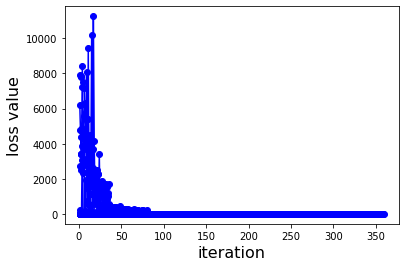

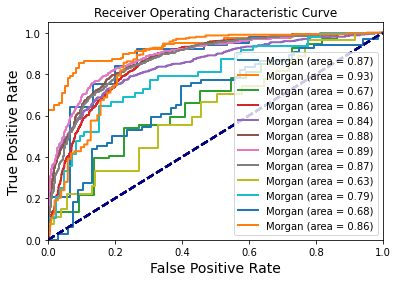

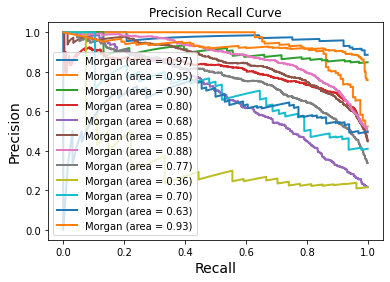

In [3]:
# extract all 21 ADME subdatasets and train/test the same model on each of them
from tdc.utils import retrieve_dataset_names
adme_datasets = retrieve_dataset_names('ADME')

for dataset_name in adme_datasets:
    print(dataset_name)
    X, y = ADME(name = dataset_name).get_data(format = 'DeepPurpose')
    drug_encoding = 'Morgan'
    train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')
    config = utils.generate_config(drug_encoding = drug_encoding, 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         mpnn_hidden_size = 32,
                         mpnn_depth = 2
                        )
    model = CompoundPred.model_initialize(**config)
    model.train(train, val, test)
    model.save_model('./' + dataset_name + '_model')

In [9]:
import os
from DeepPurpose import CompoundPred as models

# predict on Zanamivir as an example
X_repurpose = ["CC(=O)N[C@@H]1[C@H](C=C(O[C@H]1[C@@H]([C@@H](CO)O)O)C(=O)O)N=C(N)N"]
df_data, _, _ = utils.data_process(X_repurpose, y = [0], drug_encoding = model.drug_encoding)

for predictor in os.listdir("PATH_TO_MODELS/"):
  if "model" in predictor:
    model = models.model_pretrained("PATH_TO_MODELS/"+predictor)
    y_pred = model.predict(df_data)
    print(str(predictor) + ":" + str(y_pred))
  else:
    continue


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
Done.
predicting...
cyp3a4_substrate_carbonmangels_model:[0.4801250696182251]
predicting...
clearance_microsome_az_model:[28.0200138092041]
predicting...
bioavailability_ma_model:[0.5361301898956299]
predicting...
caco2_wang_model:[-5.198214530944824]
predicting...
cyp3a4_veith_model:[0.016212064772844315]
predicting...
hydrationfreeenergy_freesolv_model:[-11.744050979614258]
predicting...
cyp2c9_veith_model:[0.011897710151970387]
predicting...
bbb_martins_model:[0.22699502110481262]
predicting...
clearance_hepatocyte_az_model:[36.4248046875]
predicting...
hia_hou_model:[0.7084367275238037]
predicting...
cyp2d6_substrate_carbonmangels_model:[0.07456508278846741]
predicting...
vdss_lombardo_model:[2.968869924545288]
predicting...
cyp2d6_veith_model:[0.046608101576566696]
predicting...
cyp1a2_veith_model:[0.0013690183404833078]
predicting...
cyp2c19_veith_model:[0.014066430740058422]
predicting...
cyp2c9_

As we can see from some of the evaluation metrics and predictions, it appears that a one-size-fits-all approach does not yield optimal results. Given the highly diverse tasks at hand from a biological point of view, it may make more sense to try different models and drug encodings depending on the specific tasks and its biological characteristics.

## 4. Docking

Another key piece of information in the drug repurposing/discovery process is docking between drug (ligand) and target.

We well go back to DeepChem but will not be using machine learning this time. We will use the molecular modeling simulation software Autodock Vina, which is especially effective for protein-ligand docking, to a) identify binding pockets in the target (H5N1 NS1 protein), b) generate binding poses of our drug candidates and c) score the potential dockings.

We will use several widgets to visualize the results in 3D and we will also mention how we could try to obtain a 3D model of the folded protein with Google's Alphafold in case this is not available in Protein Data Bank.

In [ ]:
# install packages
!pip install "ipywidgets <8"
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install -q mdtraj nglview
!pip install --pre deepchem
!pip install vina

In [ ]:
import os
import numpy as np
import pandas as pd
import tempfile
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
from deepchem.utils import download_url, load_from_disk
from simtk.openmm.app import PDBFile
from pdbfixer import PDBFixer
from deepchem.utils.vina_utils import prepare_inputs
import mdtraj as md
import nglview
from IPython.display import display, Image

In [13]:
# enable third party widgets in colab to visualize molecule/drug
from google.colab import output
output.enable_custom_widget_manager()

In [50]:
# target protein and list of drug candidates
# here we use the first compound identified 
# by the property prediction model as an example
pdbid = "3F5T"
ligand = "CC(C)(C)C1=CC=C(C=C1)C(=O)NC2=CN3C=C(C=CC3=N2)N4C=CN=C4"

In [51]:
# use the application PDBFixer to fix possible problems in pdb file
%%time
fixer = PDBFixer(pdbid=pdbid)
PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

p, m = None, None
# fix protein, optimize ligand geometry, and sanitize molecules
try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand)
except:
    print('%s failed PDB fixing' % (pdbid)) 

if p and m:  # protein and molecule are readable by RDKit
    print(pdbid, p.GetNumAtoms())
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  import sys


3F5T 1469
CPU times: user 3.87 s, sys: 132 ms, total: 4 s
Wall time: 3.23 s


In [39]:
# find binding pockets
finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets('3F5T.pdb')
print("Found " + str(len(pockets)) + " pockets")

Found 46 pockets


We use the default value for num_modes when generating poses, so Vina will return the 9 lowest energy poses it found in units of kcal/mol, from better (lower energy) to worse (higher energy).

In [52]:
# generate ligand poses in binding pockets
vpg = dc.dock.pose_generation.VinaPoseGenerator()

complexes, scores = vpg.generate_poses(molecular_complex=('3F5T.pdb', 'ligand_3F5T.pdb'),  # protein-ligand files for docking,
                                       out_dir='SAVE_PATH',
                                       generate_scores=True
                                      )

/usr/local/lib/python3.7/dist-packages/vina/vina.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._voxels = np.ceil(np.array(box_size) / self._spacing).astype(np.int)


The code above will generate two lists: complexes, that contains couples of protein and docked ligand, and scores, that contains the binding affinity score for each of these complexes. One rule of thumb is to consider binding affinity lower than -6 kcal/mol as potentially significant, although this is not always true. As a reference, some results we obtained were: Methisazone -4.578, Foscarnet -2.652 and Zanamivir -3.835. As a comparison, simpe sodium chloride scores -0.733 and, interestingly, the first compound identified by the property prediction model (4-Tert-Butyl-N-[6-(1h-Imidazol-1-Yl)imidazo[1,2-A]pyridin-2-Yl]benzamide) despite not having been predicted as specifically targeting this protein shows a high score as can be seen below: 

In [53]:
scores

[-6.917, -6.651, -6.386, -6.205, -6.107, -6.069, -6.022, -6.013, -5.96]

We can now visualize the molecule docked to the protein target in 3D.

In [54]:
# combine protein and ligand in specific pose into one entity
complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])

In [55]:
# plot ligand docked in protein in 3D
v = nglview.show_rdkit(complex_mol)
display(v)

NGLWidget()

It is important to note that sanitization and docking are processes that may require human judgment and intervention to be properly performed. The previous steps offer some structured guidance but will not always necessarily provide meaningful results.

At this point it is interesting to mention Google's Aphafold. This time a 3D moded of the folded target protein was available but if this was not the case we could also try to fold it ourselves using its aminoacid chain and [Alphafold](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb). This is the result we got for the H5N1 NS1 protein:

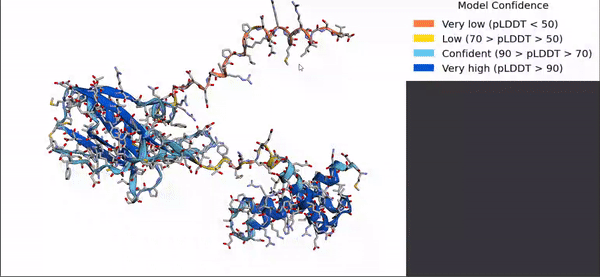

As we can see, the model is not perfect but definitely quite good. It matches the general two-domains structure and got right most of the alpha helices and beta sheets in each of them. Most importantly, it was able to give an accurate estimation of confidence that warned about very low confidence in the wrongly predicted protuberance (in orange) and low confidence in the linker region (in yellow).

## 5. (Retro)synthesis

One of the final important steps of drug repurposing/discovery is to estimate how hard synthesising the drug could be and the specific steps and reactants to achieve it. For this we will use the Synthetic Accesibility oracle through *Therapeutics Data Commons* and IBM RXN for Chemistry, respectively.

In [ ]:
# install packages
!pip install PyTDC
!pip install rdkit

The Synthetic Accessibility score aims to give an estimation about how hard or how easy it is to synthesize a given molecule based on a combination of the molecule’s fragments contributions. It goes from 1 (easiest) to 10 (hardest). This model does not take into account some important factors such as  number of steps in the predicted synthesis plan and the cost of the starting materials, these [biases and limitations](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8) of the oracle have to be considered.

In [57]:
# predict synthetic accessibility on:
# Foscarnet, Zanamivir and 4-Tert-Butyl-N-[6-(1h-Imidazol-1-Yl)imidazo[1,2-A]pyridin-2-Yl]benzamide, respectively
from tdc import Oracle
oracle = Oracle(name = 'SA')
oracle(['C(=O)(O)P(=O)(O)O', \
        'CC(=O)N[C@@H]1[C@H](C=C(O[C@H]1[C@@H]([C@@H](CO)O)O)C(=O)O)N=C(N)N', \
        'CC(C)(C)C1=CC=C(C=C1)C(=O)NC2=CN3C=C(C=CC3=N2)N4C=CN=C4'])

100%|██████████| 9.05M/9.05M [00:00<00:00, 14.4MiB/s]
Done!


[2.88975281729331, 4.28385535042811, 2.5175399478520077]

As a comparison, the toxin maitotoxin, which has been impossible to synthesize up to now despite a decades effort, scores almost 10:

In [60]:
oracle("C[C@H](CC[C@@H]([C@@H]([C@H](C)C[C@H](C(=C)/C(=C/CO)/C)O)O)OS(=O)(=O)[O-])[C@H]([C@@H](C)[C@H]1[C@@H]([C@@H]([C@H]2[C@H](O1)[C@@H](C[C@]3([C@H](O2)C[C@H]4[C@H](O3)C[C@]5([C@H](O4)[C@H]([C@H]6[C@H](O5)C[C@H]([C@H](O6)[C@@H]([C@H](C[C@H]7[C@@H]([C@@H]([C@H]8[C@H](O7)C[C@H]9[C@H](O8)C[C@H]1[C@H](O9)[C@H]([C@@H]2[C@@H](O1)[C@@H]([C@H]([C@@H](O2)[C@H]1[C@@H]([C@H]([C@H]2[C@@H](O1)C[C@H]([C@@H](O2)[C@@H](C[C@H](C[C@H]1[C@@H]([C@H]([C@H]2[C@@H](O1)C[C@H]([C@@H](O2)[C@H]1[C@@H](C[C@]2([C@H](O1)[C@@H]([C@]1([C@H](O2)C[C@]2([C@H](O1)CC[C@]1([C@H](O2)C[C@]2([C@H](O1)C[C@H]1[C@H](O2)CC[C@H](O1)[C@]1([C@@H](C[C@H]2[C@](O1)(C[C@H]1[C@](O2)(CC[C@]2([C@H](O1)C[C@H]1[C@](O2)(C[C@H]2[C@H](O1)C/C=C\[C@H]1[C@H](O2)C[C@H]2[C@](O1)(C[C@]1([C@H](O2)C[C@H]2[C@](O1)(CC[C@H](O2)[C@H]([C@@H](C[C@@H](C)[C@@H](C)CC=C)O)O)C)C)C)C)C)C)C)O)C)C)C)C)C)O)C)O)O)O)O)O)O)O)O)O)O)O)O)O)OS(=O)(=O)[O-])O)O)O)O)C)C)O)O)O)O.[Na+].[Na+]")

9.940362044072216

And Aspirin just 1.5:

In [61]:
oracle("CC(=O)OC1=CC=CC=C1C(=O)O")

1.580039750008826

Finally, we use IBM RXN for Chemistry, a digital chemistry tool based on the Molecular Transformer, to perform retrosynthesis (obtain the necessary reactants starting from our final product).
Although there is a [python wrapper](https://github.com/rxn4chemistry/rxn4chemistry) to access the API of IBM RXN for Chemistry, we will be showing the results obtained using the GUI since for some unkown reason the results varied (for worse) when using the API with the wrapper.

We just create a free account [here](https://rxn.res.ibm.com/), start a new "Predict retrosynthesis routes" project and enter the target molecules in SMILES format in the SMILES string editor. There are several interesting options such as type of model, etc. that can be used to optimize the results. Some results for 4-Tert-Butyl-N-[6-(1h-Imidazol-1-Yl)imidazo[1,2-A]pyridin-2-Yl]benzamide:

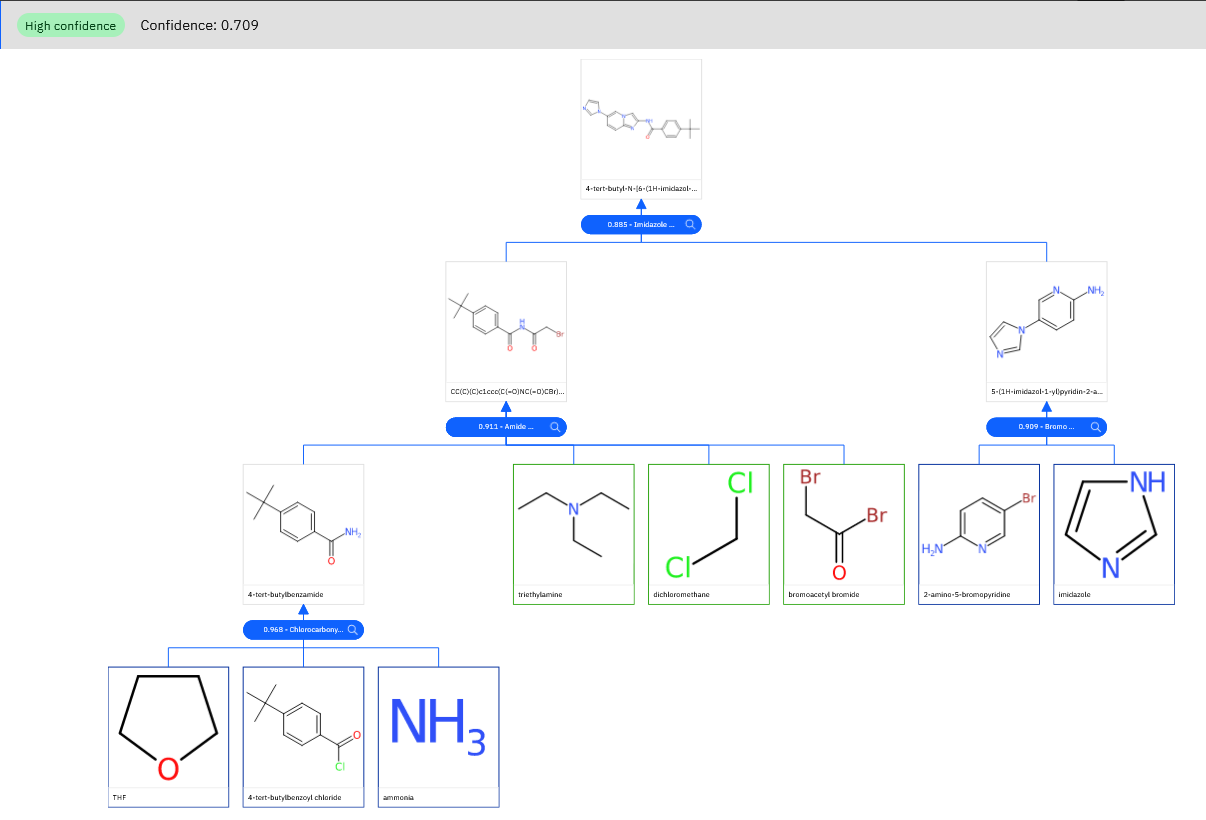

## Acknowledgment

Material adapted from different [DeepChem](https://github.com/deepchem/deepchem), [DeepPurpose](https://github.com/kexinhuang12345/DeepPurpose) and [Therapeutics Data Commons](https://github.com/mims-harvard/TDC) tutorials, among others. Make sure to check the corresponding repositories for more in depth information.